 Problem Sheet 2, Jelmer Bennema, Oct 31st 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import SplineTransformer

# country zone for data -> numeric 
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

# Q1: Data Report

In [2]:
# Download data 
IR = pd.read_csv('data/IR.csv')
Repossession = pd.read_csv('data/repossession.csv')
Unemployment = pd.read_csv('data/unemployment.csv').rename(columns = {'Rate':'unemployment rate'})

In [3]:
# transform index to datetime object for all three dataframes 
IR['date time'] = pd.to_datetime(IR['DATE']).dt.year
IR.drop(columns = ['DATE'], inplace = True)
IR.set_index('date time', inplace = True, drop = True)

Repossession['datetime1'] = pd.to_datetime(Repossession['year'], format = '%Y').dt.year
Repossession.drop(columns = ['year'], inplace = True)
Repossession.set_index('datetime1', inplace = True, drop = True)

#Replace object values with floats
for i in range(0, len(Repossession)):
        Repossession['num_mortage'].iloc[i] = locale.atoi(Repossession['num_mortage'].iloc[i])
        Repossession['num_possession'].iloc[i] = locale.atoi(Repossession['num_possession'].iloc[i])
        
Repossession['num_possession'] = Repossession['num_possession'].astype('float')
Repossession['num_mortage'] = Repossession['num_mortage'].astype('float')

Unemployment.set_index('Year', inplace = True, drop = True)

In [4]:
# merge dataframes
df = pd.concat([IR, Repossession, Unemployment], axis = 1, join = 'inner')
df.head(3)

,RATE,num_mortage,num_possession,unemployment rate
1975,11.0000,5076000.0,4870.0,4.5
1976,11.1137,5322000.0,4950.0,5.4
1977,8.8772,5582000.0,4680.0,5.6


In [5]:
df.tail(3)

,RATE,num_mortage,num_possession,unemployment rate
2011,0.5,11384000.0,37300.0,8.1
2012,0.5,11284000.0,33900.0,8.0
2013,0.5,11186000.0,28900.0,7.6


In [6]:
df.dtypes

RATE                 float64
num_mortage          float64
num_possession       float64
unemployment rate    float64
dtype: object

## Analyze Data

In [7]:
df.isna().sum()  #Checking for null values

RATE                 0
num_mortage          0
num_possession       0
unemployment rate    0
dtype: int64

In [8]:
df.describe(include = 'all')

,RATE,num_mortage,num_possession,unemployment rate
count,39.000000,3.900000e+01,39.000000,39.000000
mean,7.593882,9.399205e+06,25763.846154,7.517949
std,4.290191,2.227783e+06,18939.563939,2.236877
min,0.500000,5.076000e+06,2910.000000,4.500000
25%,4.664450,7.515000e+06,8450.000000,5.400000
50%,6.694900,1.041000e+07,22900.000000,7.200000
75%,10.941450,1.129350e+07,37900.000000,9.200000
max,16.309100,1.185200e+07,75500.000000,11.800000


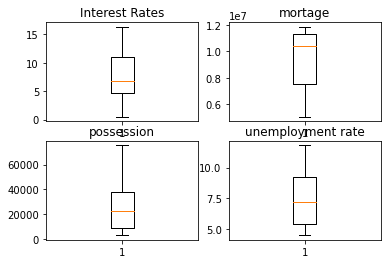

In [9]:
plt.subplot(2, 2, 1)
plt.boxplot(df['RATE'])
plt.title('Interest Rates')

plt.subplot(2, 2, 2)
plt.boxplot(df['num_mortage'])
plt.title('mortage')

plt.subplot(2, 2, 3)
plt.boxplot(df['num_possession'])
plt.title('possession')

plt.subplot(2, 2, 4)
plt.boxplot(df['unemployment rate'])
plt.title('unemployment rate')

plt.show()

array([[<AxesSubplot:title={'center':'num_mortage'}>,
        <AxesSubplot:title={'center':'num_possession'}>],
       [<AxesSubplot:title={'center':'unemployment rate'}>,
        <AxesSubplot:title={'center':'RATE'}>]], dtype=object)

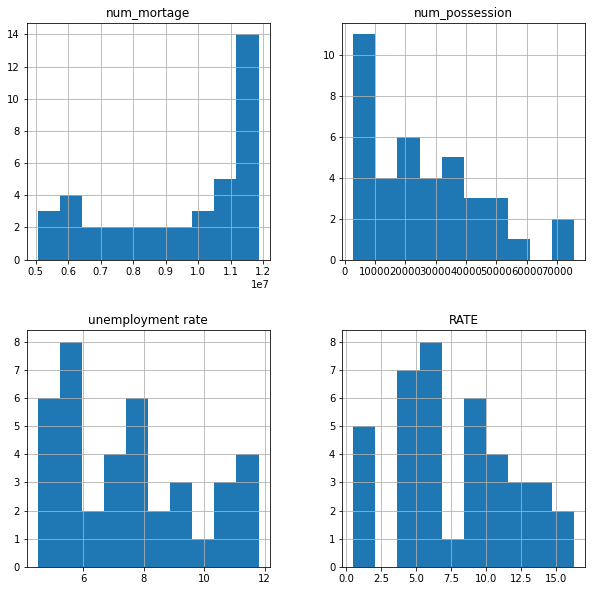

In [10]:
df[['num_mortage','num_possession','unemployment rate','RATE']].hist(figsize=(10,10))

In [11]:
# normalize dataset
df_norm = (df - df.mean())/np.std(df)
df_norm.head(3)

,RATE,num_mortage,num_possession,unemployment rate
1975,0.804310,-1.965955,-1.117607,-1.366817
1976,0.831159,-1.854087,-1.113327,-0.959211
1977,0.303039,-1.735854,-1.127770,-0.868631


## Perform data analysis

(d) Note: you should try simple regression models, polynomial regression
and splines (no need for kernel regression). Consider which features to
include and if normalising the data improves the model. Also use appropriate model selection criteria to support your conclusions

In [12]:
data_train,data_test = train_test_split(df ,test_size=0.3,random_state=0)

X_train = data_train[['num_mortage','num_possession','unemployment rate']]
y_train = data_train['RATE']

X_test = data_test[['num_mortage','num_possession','unemployment rate']]
y_test = data_test['RATE']

len(X_test),len(X_train),len(y_train),len(y_test)

(12, 27, 27, 12)

## OLS Regression

In [13]:
# all variables 
OLS = sm.OLS(y_train, sm.add_constant(X_train)).fit()
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RATE   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     10.72
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           0.000133
Time:                        11:46:19   Log-Likelihood:                -65.261
No. Observations:                  27   AIC:                             138.5
Df Residuals:                      23   BIC:                             143.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                20.5413      3.866      5.314      0.000      12.544      28.538
num_mortage       -1.564e-06   3.38e-07     -4.629      0.000   -2.26e-06   -8.65e-07
num_possession     3.996e-05   4.15e-05      0.963      0.346   -4.59e-05       0.000
unemployment rate     0.0541      0.300      0.180      0.858      -0.566       0.674
==============================================================================
Omnibus:                        0.274   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.872   Jarque-Bera (JB):                0.210
Skew:                           0.188   Prob(JB):                        0.900
Kurtosis:                       2.785   Cond. No.                     6.43e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
# all variables - normalized
data_train_norm,data_test_norm = train_test_split(df_norm ,test_size=0.3,random_state=0)

X_train_norm = data_train_norm[['num_mortage', 'num_possession', 'unemployment rate']]
y_train_norm = data_train_norm['RATE']

OLS = sm.OLS(y_train_norm, sm.add_constant(X_train_norm)).fit()
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RATE   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     10.72
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           0.000133
Time:                        11:46:19   Log-Likelihood:                -26.291
No. Observations:                  27   AIC:                             60.58
Df Residuals:                      23   BIC:                             65.76
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0750      0.135     -0.555      0.584      -0.354       0.204
num_mortage          -0.8122      0.175     -4.629      0.000      -1.175      -0.449
num_possession        0.1764      0.183      0.963      0.346      -0.203       0.556
unemployment rate     0.0282      0.156      0.180      0.858      -0.295       0.351
==============================================================================
Omnibus:                        0.274   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.872   Jarque-Bera (JB):                0.210
Skew:                           0.188   Prob(JB):                        0.900
Kurtosis:                       2.785   Cond. No.                         2.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# significant variables 
X_train_new = data_train[['num_mortage']]
y_train_new = data_train['RATE']

OLS = sm.OLS(y_train_new, sm.add_constant(X_train_new)).fit()
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RATE   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     31.59
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           7.56e-06
Time:                        11:46:19   Log-Likelihood:                -66.038
No. Observations:                  27   AIC:                             136.1
Df Residuals:                      25   BIC:                             138.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          20.1232      2.275      8.845      0.000      15.438      24.809
num_mortage -1.362e-06   2.42e-07     -5.620      0.000   -1.86e-06   -8.63e-07
==============================================================================
Omnibus:                        0.199   Durbin-Watson:                   1.489
Prob(Omnibus):                  0.905   Jarque-Bera (JB):                0.349
Skew:                           0.169   Prob(JB):                        0.840
Kurtosis:                       2.557   Cond. No.                     3.83e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'OLS regression with selected and normalized data')

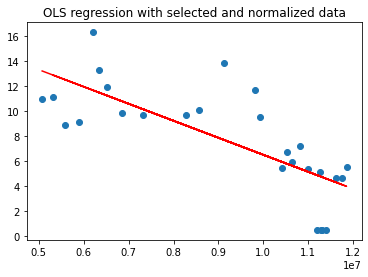

In [16]:
# scatter regression 
ypred = OLS.predict(sm.add_constant(X_train_new))
plt.scatter(X_train_new, y_train_new)
plt.plot(X_train_new.values, ypred.values, color = 'red')
plt.title('OLS regression with selected and normalized data')

## Polynomial Regression

In [17]:
polynomial_features= PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(X_train_norm)
xp.shape

(27, 10)

In [18]:
# all variables - normalized
poly = sm.OLS(y_train_norm, sm.add_constant(xp)).fit()
poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RATE   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     13.85
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           3.45e-06
Time:                        11:46:19   Log-Likelihood:                -9.4713
No. Observations:                  27   AIC:                             38.94
Df Residuals:                      17   BIC:                             51.90
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6608      0.262      2.520      0.022       0.108       1.214
x1            -1.8559      0.443     -4.187      0.001      -2.791      -0.921
x2             0.3879      0.466      0.833      0.416      -0.594       1.370
x3            -0.7661      0.262     -2.925      0.009      -1.319      -0.214
x4            -0.7952      0.381     -2.088      0.052      -1.598       0.008
x5             0.1317      0.550      0.239      0.814      -1.029       1.292
x6            -0.7302      0.309     -2.364      0.030      -1.382      -0.079
x7            -0.0175      0.194     -0.090      0.929      -0.427       0.392
x8             0.2508      0.309      0.811      0.428      -0.401       0.903
x9            -0.1716      0.182     -0.940      0.360      -0.557       0.213
==============================================================================
Omnibus:                        0.518   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.772   Jarque-Bera (JB):                0.039
Skew:                           0.067   Prob(JB):                        0.981
Kurtosis:                       3.130   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
polynomial_features= PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(X_train_new)

# significant variables 
poly = sm.OLS(y_train, sm.add_constant(xp)).fit()
poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RATE   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     50.73
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.82e-07
Time:                        11:46:19   Log-Likelihood:                -62.104
No. Observations:                  27   AIC:                             128.2
Df Residuals:                      25   BIC:                             130.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.269e-13   7.17e-14     12.927      0.000    7.79e-13    1.07e-12
x1          3.766e-06   2.91e-07     12.927      0.000    3.17e-06    4.37e-06
x2         -3.009e-13   2.83e-14    -10.638      0.000   -3.59e-13   -2.43e-13
==============================================================================
Omnibus:                        0.775   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.679   Jarque-Bera (JB):                0.744
Skew:                           0.134   Prob(JB):                        0.690
Kurtosis:                       2.232   Cond. No.                     1.97e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+15. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Polynomial Regression')

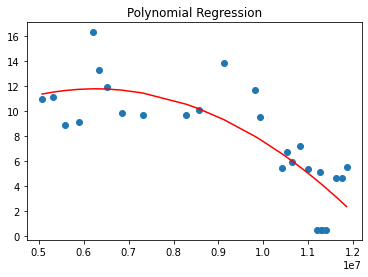

In [20]:
# scatter regression 
ypred = poly.predict(sm.add_constant(xp))

plt.scatter(X_train_new, y_train)

# sort and plot model output 
xs, ys = zip(*sorted(zip(X_train_new.values, ypred)))
plt.plot(xs, ys, color = 'red')
plt.title('Polynomial Regression')

## Splines Regression

In [21]:
# Generating cubic spline with 3 knots 
transformed_x = dmatrix(
            "bs(train, knots=(0.7e7,0.9e7, 1.1e7), degree=3, include_intercept=False)", 
                {"train": X_train_new},return_type='dataframe')

In [22]:
transformed_x.head(3)

,Intercept,"bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[0]","bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[1]","bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[2]","bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[3]","bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[4]","bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[5]"
1977,1.0,0.511227,0.085550,0.002897,0.000000,0.000000,0.000000
2013,1.0,0.000000,0.000000,0.025056,0.337249,0.627291,0.010404
1995,1.0,0.000000,0.002319,0.181554,0.599826,0.216301,0.000000


In [23]:
spline = sm.OLS(y_train_new, transformed_x).fit()
spline_pred = spline.predict(transformed_x)
spline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RATE   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     13.97
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           3.17e-06
Time:                        11:46:19   Log-Likelihood:                -54.836
No. Observations:                  27   AIC:                             123.7
Df Residuals:                      20   BIC:                             132.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                        9.7120      1.868      5.200      0.000       5.816      13.608
bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[0]     4.2986      4.026      1.068      0.298      -4.099      12.696
bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[1]    -1.4006      3.554     -0.394      0.698      -8.814       6.013
bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[2]     3.6705      3.888      0.944      0.356      -4.440      11.781
bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[3]    -1.5379      2.945     -0.522      0.607      -7.681       4.605
bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[4]   -10.6278      2.650     -4.011      0.001     -16.155      -5.100
bs(train, knots=(0.7e7, 0.9e7, 1.1e7), degree=3, include_intercept=False)[5]    -3.2304      2.564     -1.260      0.222      -8.579       2.118
==============================================================================
Omnibus:                        1.225   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.542   Jarque-Bera (JB):                1.130
Skew:                           0.445   Prob(JB):                        0.568
Kurtosis:                       2.540   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Cubic Splines Output')

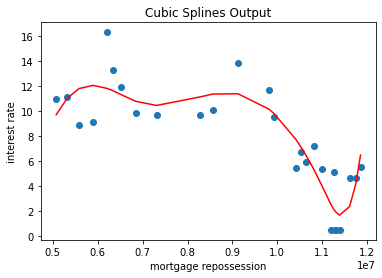

In [24]:
plt.scatter( X_train_new, y_train)

# sort values and plot model output
xs, ys = zip(*sorted(zip(X_train_new.values, spline_pred)))
plt.plot(xs, ys, color = 'red')
plt.xlabel('mortgage repossession')
plt.ylabel('interest rate')
plt.title('Cubic Splines Output')

## Test Model Performance

In [25]:
rmse = {}
  
# OLS
OLS_pred = OLS.predict(sm.add_constant(data_test[['num_mortage']]))
rmse['OLS'] = mean_squared_error(data_test['RATE'], OLS_pred, squared = False)

# Polynomial 
xp = polynomial_features.fit_transform(data_test[['num_mortage']])
xp.shape

poly_pred = poly.predict(sm.add_constant(xp))
rmse['poly'] = mean_squared_error(data_test[['RATE']], poly_pred, squared = False)

# Spline  
transformed_x = dmatrix(
            "bs(train, knots=(0.7e7,0.9e7, 1.1e7), degree=3, include_intercept=False)", 
                {"train": data_test[['num_mortage']]},return_type='dataframe')
spline_pred = spline.predict(transformed_x)
rmse['spline'] = mean_squared_error(data_test[['RATE']], spline_pred, squared = False)

Text(0, 0.5, 'rmse')

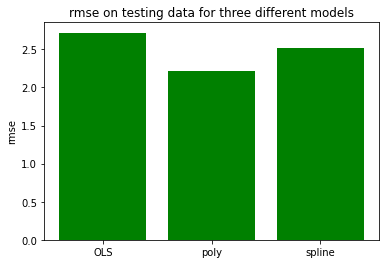

In [26]:
plt.bar(rmse.keys(), rmse.values(), color='g')
plt.title('rmse on testing data for three different models')
plt.ylabel('rmse')

# Q1: Weighted Linear Regression 

In [27]:
df_WLS = (
    pd.read_csv('data/Python_DataQ2.csv')
    .drop('Unnamed: 0', axis = 1)
    .dropna()
)
df_WLS.head()

,x,y_data,weights
0,0.000000,5.812224,1.0
1,0.408163,5.119555,1.0
2,0.816327,5.960221,1.0
3,1.224490,5.754320,1.0
4,1.632653,5.932048,1.0


## OLS regression (a)

In [28]:
ols = sm.OLS(df_WLS['y_data'], sm.add_constant(df_WLS['x'])).fit()
ols_pred = ols.predict(sm.add_constant(df_WLS['x']))
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_data   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     347.7
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.25e-23
Time:                        11:46:19   Log-Likelihood:                -68.470
No. Observations:                  50   AIC:                             140.9
Df Residuals:                      48   BIC:                             144.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2426      0.271     19.370      0.000       4.698       5.787
x              0.4349      0.023     18.647      0.000       0.388       0.482
==============================================================================
Omnibus:                       10.697   Durbin-Watson:                   2.200
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               29.315
Skew:                           0.153   Prob(JB):                     4.31e-07
Kurtosis:                       6.739   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'OLS regression x vs y')

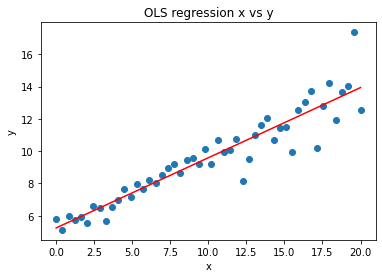

In [29]:
# plot fitted values vs original data 
plt.scatter(df_WLS['x'], df_WLS['y_data'])
plt.plot( df_WLS['x'], ols_pred, color = 'r')
plt.xlabel('x');plt.ylabel('y')
plt.title('OLS regression x vs y')

Text(0.5, 1.0, 'x vs residuals')

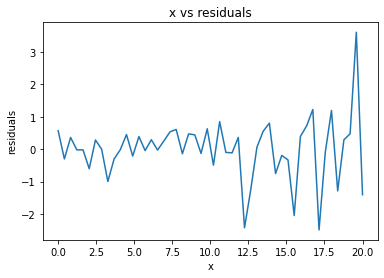

In [30]:
# plot residuals vs x 
residuals = df_WLS['y_data'] - ols_pred
plt.plot(df_WLS['x'], residuals)
plt.xlabel('x'); plt.ylabel('residuals')
plt.title('x vs residuals')

Residuals seem to grow as x grows larger. i.e. they are not independent of x 

## Weighted Linear regression (b)

In [31]:
wls = sm.OLS(df_WLS['y_data'], sm.add_constant(df_WLS['weights'] * df_WLS['x'])).fit()
wls_pred = wls.predict(sm.add_constant(df_WLS['x']))
wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_data   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     133.4
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.84e-15
Time:                        11:46:19   Log-Likelihood:                -87.971
No. Observations:                  50   AIC:                             179.9
Df Residuals:                      48   BIC:                             183.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0892      0.297     23.885      0.000       6.492       7.686
0              0.1093      0.009     11.550      0.000       0.090       0.128
==============================================================================
Omnibus:                        0.374   Durbin-Watson:                   1.223
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.375
Skew:                           0.189   Prob(JB):                        0.829
Kurtosis:                       2.810   Cond. No.                         45.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
## Display the estimated coefficients from WLS alongside the ones from OLS 
print('WLS coefficients: \n', wls.params)
print('OLS coefficients: \n',ols.params)

WLS coefficients: 
 const    7.089235
0        0.109268
dtype: float64
OLS coefficients: 
 const    5.242561
x        0.434869
dtype: float64


In [33]:
print('WLS std: \n', wls.bse)
print('OLS std: \n',ols.bse)

WLS std: 
 const    0.296803
0        0.009461
dtype: float64
OLS std: 
 const    0.270653
x        0.023321
dtype: float64


Text(0.5, 1.0, 'WLS regression x vs y')

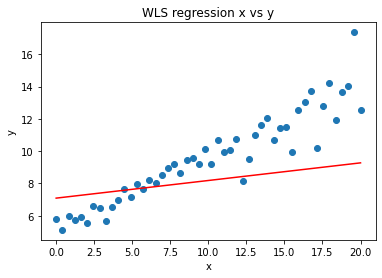

In [34]:
# plot fitted values vs original data 
plt.scatter(df_WLS['x'], df_WLS['y_data'])
plt.plot( df_WLS['x'], wls_pred, color = 'r')
plt.xlabel('x');plt.ylabel('y')
plt.title('WLS regression x vs y')

Text(0.5, 1.0, 'x vs residuals')

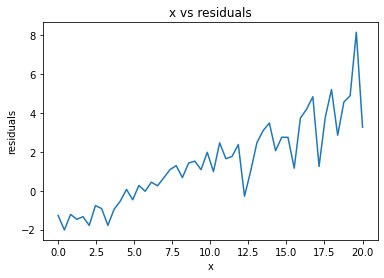

In [35]:
# plot residuals vs x 
residuals = df_WLS['y_data'] - wls_pred
plt.plot(df_WLS['x'], residuals)
plt.xlabel('x'); plt.ylabel('residuals')
plt.title('x vs residuals')

# Optimal Spline Approximation

We seek to fit a model of the form Yi = f (xi) + σi
. Write a Python
script/notebook which searches for the optimal spline approximation to
this model (with knots given by the quantiles of x ), using the AIC as an
optimality criterion. Your script should take vectors y and x as inputs,
and return the number of knots in the optimal model. You may assume
that the optimal number of knots is less than sqrt (length (x) ), and that
the vector x has at least this many distinct quantiles.

In [36]:
def spline_optimization(x, y):
    
    knots = np.arange(2, int(np.sqrt(len(x))), 1) # vector of possible knots 
    aic = np.zeros(len(knots))
    
    ######### compute spline regression for each knot option ##########
    for i in knots: 
        # Generating cubic spline - save AIC
        transformed_x = SplineTransformer(n_knots=i, degree=1, knots='quantile').fit_transform(x)
        
        spline = sm.OLS(y, transformed_x).fit()
        aic[i-2] = spline.aic

    # find best #knots and return
    return np.argmin(aic)
      

# Logistic Regression